# Introducción a la Ciencia de Datos: Tarea 2

Este notebook contiene el código de base para realizar la Tarea 2 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/).

**Se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.

## Cargar dependencias
Para esta tarea, se han agregado algunos requerimientos, asegúrese de instalarlos (puede usar el mismo entorno virtual de la Tarea 1):

In [113]:
!pip install jupyter pandas "sqlalchemy<2.0" pymysql seaborn pillow scikit-learn

zsh:1: command not found: pip


In [114]:
#No me funciona el código de arriba.
#pip install jupyter pandas "sqlalchemy<2.0" pymysql seaborn pillow scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.2.1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [115]:
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

## Conexión a la Base y Lectura de Datos

In [116]:
# DataFrame con todas las obras:
df_works = pd.read_csv('../data/shakespeare/works.csv')

# Todos los párrafos de todas las obras
df_paragraphs = pd.read_csv('../data/shakespeare/paragraphs.csv')

# Todos los capítulos de todas las obras
df_chapters = pd.read_csv('../data/shakespeare/chapters.csv')

# Todos los personakes de todas las obras
df_characters = pd.read_csv('../data/shakespeare/characters.csv')

In [117]:
df_paragraphs

,Unnamed: 0,id,ParagraphNum,PlainText,character_id,chapter_id
0,0,630863,3,"[Enter DUKE ORSINO, CURIO, and other Lords; Mu...",1261,18704
1,1,630864,4,"If music be the food of love, play on;\nGive m...",840,18704
2,2,630865,19,"Will you go hunt, my lord?",297,18704
3,3,630866,20,"What, Curio?",840,18704
4,4,630867,21,The hart.,297,18704
...,...,...,...,...,...,...
35460,35460,666323,3460,"That she is living,\nWere it but told you, sho...",866,19648
35461,35461,666324,3467,"You gods, look down\nAnd from your sacred vial...",584,19648
35462,35462,666325,3475,There's time enough for that;\nLest they desir...,866,19648
35463,35463,666326,3483,"O, peace, Paulina!\nThou shouldst a husband ta...",667,19648


## Limpieza de Texto

In [118]:
# TODO: Actualizar con su versión de clean_text() de la Tarea_1

def clean_text(df, column_name):
    # Convertir todo a minúsculas
    result = df[column_name].str.lower()

    # Quitar signos de puntuación y cambiarlos por espacios (" ")
    # TODO: completar signos de puntuación faltantes 
    # Se agregan: ";","]",".","?",":","!","\"","\'","(",")","--"
    for punc in ["[", "\n", ",",";","]",".","?",":","!","\"","(",")","--"]:
        result = result.str.replace(punc, " ")
    # No se cambia el 's porque a veces es is y a veces es brother's... haciendo referencia a pertenencia
    # No se cambia 'd porque a veces es pasado y a veces would

    #El siguiente código encuentra que i´ll es una palabra muy usada, por ende se separa:
    #agrupado = df_words.groupby("word").size().sort_values(ascending=False)
    #filtrado = agrupado[agrupado <3].sort_values(ascending=False)
    #filtrado
        
    result = result.str.replace("i'll", "i will")
    result = result.str.replace("there's", "there is")
    result = result.str.replace("that's", "that is")
    result = result.str.replace("who's", "who is")
    
    return result


# Creamos una nueva columna CleanText a partir de PlainText
df_paragraphs["CleanText"] = clean_text(df_paragraphs, "PlainText")

# Veamos la diferencia
df_paragraphs[["PlainText", "CleanText"]]

,PlainText,CleanText
0,"[Enter DUKE ORSINO, CURIO, and other Lords; Mu...",enter duke orsino curio and other lords mu...
1,"If music be the food of love, play on;\nGive m...",if music be the food of love play on give me...
2,"Will you go hunt, my lord?",will you go hunt my lord
3,"What, Curio?",what curio
4,The hart.,the hart
...,...,...
35460,"That she is living,\nWere it but told you, sho...",that she is living were it but told you shou...
35461,"You gods, look down\nAnd from your sacred vial...",you gods look down and from your sacred vials...
35462,There's time enough for that;\nLest they desir...,there is time enough for that lest they desir...
35463,"O, peace, Paulina!\nThou shouldst a husband ta...",o peace paulina thou shouldst a husband tak...


In [119]:
# Agregamos personajes, obras y géneros en el mismo dataset
df_dataset = df_paragraphs.merge(df_chapters.set_index("id")["work_id"], left_on="chapter_id", right_index=True)
df_dataset = df_dataset.merge(df_works.set_index("id")[["Title", "GenreType"]], left_on="work_id", right_index=True)
df_dataset = df_dataset.merge(df_characters.set_index('id')["CharName"], left_on="character_id", right_index=True).sort_index()
df_dataset = df_dataset[["CleanText", "CharName", "Title", "GenreType"]]

# Usaremos sólo estos personajes
characters = ["Antony", "Cleopatra", "Queen Margaret"]
df_dataset = df_dataset[df_dataset["CharName"].isin(characters)]

df_dataset

,CleanText,CharName,Title,GenreType
2058,if it be love indeed tell me how much,Cleopatra,Antony and Cleopatra,Tragedy
2059,there is beggary in the love that can be recko...,Antony,Antony and Cleopatra,Tragedy
2060,i will set a bourn how far to be beloved,Cleopatra,Antony and Cleopatra,Tragedy
2061,then must thou needs find out new heaven new ...,Antony,Antony and Cleopatra,Tragedy
2064,grates me the sum,Antony,Antony and Cleopatra,Tragedy
...,...,...,...,...
27583,thou hadst a clarence too and richard kill'd ...,Queen Margaret,Richard III,History
27585,bear with me i am hungry for revenge and now...,Queen Margaret,Richard III,History
27587,i call'd thee then vain flourish of my fortune...,Queen Margaret,Richard III,History
27589,forbear to sleep the nights and fast the days...,Queen Margaret,Richard III,History


In [120]:
# Párrafos por cada personaje seleccionado
df_dataset["CharName"].value_counts()

CharName
Antony            253
Cleopatra         204
Queen Margaret    169
Name: count, dtype: int64

## Dataset y Features de texto

In [121]:
X = df_dataset["CleanText"].to_numpy()
y = df_dataset["CharName"].to_numpy()

In [122]:
# TODO: Partir train/test 30% estratificados
# Definir X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


print(f"Tamaños de Train/Test: {len(X_train)}/{len(X_test)}")

Tamaños de Train/Test: 438/188


In [123]:
unique, counts = np.unique(y, return_counts=True)
counts

array([253, 204, 169])

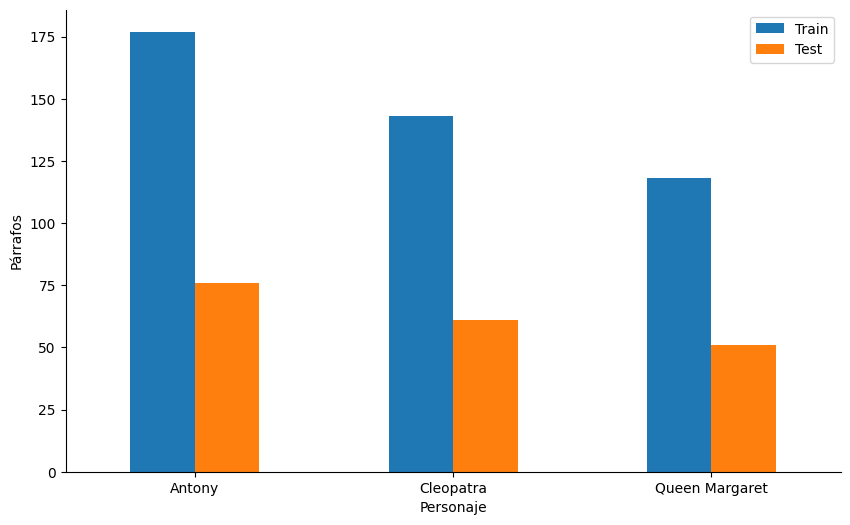

In [124]:
# Genere una visualización que permita verificar que el balance de párrafos de cada
# personaje es similar en train y test.

train_data = pd.DataFrame({'CleanText': X_train, 'CharName': y_train})
test_data = pd.DataFrame({'CleanText': X_test, 'CharName': y_test})
train_counts = train_data['CharName'].value_counts().sort_index()
test_counts = test_data['CharName'].value_counts().sort_index()
counts_df = pd.DataFrame({'Train': train_counts, 'Test': test_counts})

counts_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Personaje')
plt.ylabel('Párrafos')
plt.xticks(rotation=0)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()



Transforme el texto del conjunto de entrenamiento a la representación numérica
(features) de conteo de palabras o bag of words. Explique brevemente cómo funciona
esta técnica y muestre un ejemplo. En particular explique el tamaño de la matriz
resultante, y la razón por la que es una sparse matrix.

In [125]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
print(X_train_bow[:5].toarray())

# La técnica de bag of words es agregar todas las palabras a una matriz y contabilizar sus ocurrencias. Como primer paso 
# se gebera un vocabulario, luego se tokenizan las palabras y se pasan a una matriz donde las filas representan los documentos 
# y las columnas las palabras.
# Es una matriz dispersa porque tiene muchos ceros.
# TO-DO: agregar ejemplo.

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Conteo de palabras y TF-IDF

In [126]:
count_vect = CountVectorizer(stop_words='english', ngram_range=(1,1))
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts

<438x2591 sparse matrix of type '<class 'numpy.int64'>'
	with 5946 stored elements in Compressed Sparse Row format>

In [127]:
X_train_counts.shape

bag_of_words = X_train_counts.toarray()
bag_of_words_output = pd.DataFrame(data = bag_of_words, columns = count_vect.get_feature_names_out())
bag_of_words_output.T.tail(7).iloc[:,400:413]

,400,401,402,403,404,405,406,407,408,409,410,411,412
yond,0,0,0,0,0,0,0,0,0,0,0,0,0
yonder,0,0,0,0,0,0,0,0,0,0,0,0,0
york,0,0,0,0,0,0,0,0,0,0,0,0,0
yorks,0,0,0,0,0,0,0,0,0,0,0,0,0
young,0,0,0,0,0,0,0,0,0,0,0,0,0
younger,0,0,0,0,0,0,0,0,0,0,0,0,0
youth,0,0,0,0,0,0,0,0,0,0,0,0,0


In [128]:
bag_of_words_output.T.tail(25)

,0,1,2,3,4,5,6,7,8,9,...,428,429,430,431,432,433,434,435,436,437
wrestle,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wretch,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wretched,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wrinkled,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
writ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
write,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wrong,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wrongs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yard,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yare,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
bag_of_words_output.describe()

,abhorring,abides,abjects,abode,abroad,absence,abused,abysm,accident,accidents,...,yield,yielded,yoke,yond,yonder,york,yorks,young,younger,youth
count,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,...,438.000000,438.000000,438.000000,438.000000,438.000000,438.00000,438.000000,438.000000,438.000000,438.000000
mean,0.002283,0.002283,0.002283,0.002283,0.004566,0.002283,0.002283,0.002283,0.002283,0.004566,...,0.009132,0.002283,0.002283,0.002283,0.002283,0.02968,0.002283,0.009132,0.002283,0.011416
std,0.047782,0.047782,0.047782,0.047782,0.067496,0.047782,0.047782,0.047782,0.047782,0.067496,...,0.095235,0.047782,0.047782,0.047782,0.047782,0.28144,0.047782,0.095235,0.047782,0.106353
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,5.00000,1.000000,1.000000,1.000000,1.000000


In [130]:
bag_of_words_output.max().sort_values(ascending=False)

thy         13
brutus       9
thee         8
caesar       8
thou         7
            ..
fully        1
fumblest     1
funeral      1
fury         1
youth        1
Length: 2591, dtype: int64

In [131]:
bag_of_words_output["yonder"].sum()

np.int64(1)

In [132]:
count_vect.vocabulary_.get(u'love')

1308

In [133]:
tf_idf = TfidfTransformer(use_idf=False)
X_train_tf = tf_idf.fit_transform(X_train_counts)
X_train_tf

<438x2591 sparse matrix of type '<class 'numpy.float64'>'
	with 5946 stored elements in Compressed Sparse Row format>

In [134]:
X_train_tf.shape

(438, 2591)

In [135]:
tfidf_array = X_train_tf.toarray()
tfidf_output = pd.DataFrame(data = tfidf_array, columns = count_vect.get_feature_names_out())
tfidf_output.T.tail(25)

,0,1,2,3,4,5,6,7,8,9,...,428,429,430,431,432,433,434,435,436,437
wrestle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wretch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wretched,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wrinkled,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
writ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
write,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wrong,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wrongs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yare,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Reducción de dimensionalidad

In [136]:
# TODO: Realizar PCA sobre los datos de entrenamiento
from sklearn.decomposition import PCA
reductor = PCA(n_components=2)
#reductor = PCA()

# Transformar train
X_train_red = reductor.fit_transform(X_train_tf.toarray())

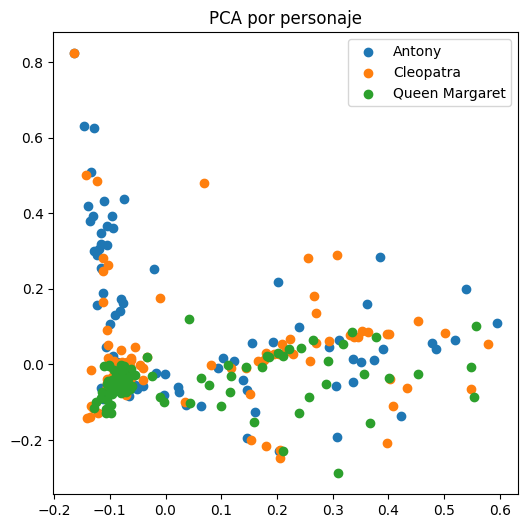

In [137]:
# Visualización de las dos primeras componentes de PCA
fig, ax = plt.subplots(figsize=(6, 6))
for character in np.unique(y_train):
    mask_train = y_train == character
    ax.scatter(X_train_red[mask_train, 0], X_train_red[mask_train, 1], label=character)

ax.set_title("PCA por personaje")
ax.legend()

## Modelos de Clasificación

In [138]:
bayes_clf = MultinomialNB().fit(X_train_tf, y_train)

# Ver las primeras 10 predicciones de train
y_pred_train = bayes_clf.predict(X_train_tf)
y_pred_train[:10]

array(['Queen Margaret', 'Antony', 'Cleopatra', 'Antony', 'Cleopatra',
       'Cleopatra', 'Antony', 'Antony', 'Antony', 'Antony'], dtype='<U14')

In [139]:
def get_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

get_accuracy(y_train, y_pred_train)

np.float64(0.8926940639269406)

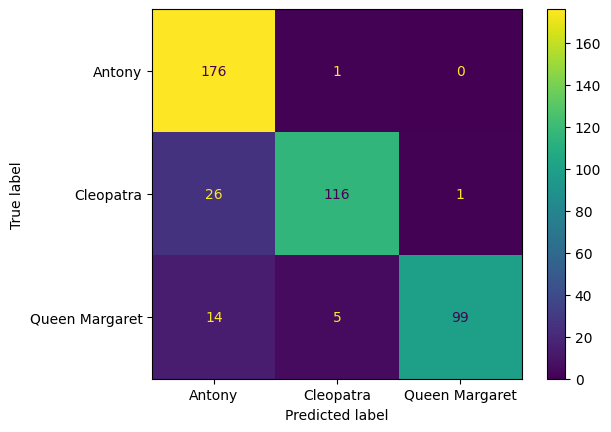

In [140]:
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=bayes_clf.classes_)
disp.plot()

In [ ]:
# TODO: Predecir para test y ver la matriz de confusión, y reportar accuracy

# X_test_counts = ...
# X_test_tfidf = ...
# y_test_pred = ...
# X_test_counts = count_vect.fit_transform(X_test)
# X_test_tf = tf_idf.fit_transform(X_test_counts)
# y_pred_test = bayes_clf.predict(X_test_tf)


### Búsqueda de hiper-parámetros con Cross-Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

# TODO: Agregar más variantes de parámetros que les parezcan relevantes
param_sets = [{"stop_words": None, "ngram": (1,2), "idf": True},
             {"stop_words": None, "ngram": (1,1), "idf": False}]

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Ahora usaremos train/validation/test
# Por lo tanto le renombramos train+validation = dev(elopment) dataset
X_dev = X_train
y_dev = y_train

# # Para evitar errores
# del X_train
# del y_train

for params in param_sets:
    
    # Transormaciones a aplicar (featurizers)
    count_vect = CountVectorizer(stop_words=params["stop_words"], ngram_range=params["ngram"])
    tf_idf = TfidfTransformer(use_idf=params["idf"])
    
    for train_idxs, val_idxs in skf.split(X_dev, y_dev):
        
        # Train y validation para el split actual
        X_train_ = X_dev[train_idxs]
        y_train_ = y_dev[train_idxs]
        X_val = X_dev[val_idxs]
        y_val = y_dev[val_idxs]
        
        # Ajustamos y transformamos Train
        X_train_counts = count_vect.fit_transform(X_train_)
        X_train_tf = tf_idf.fit_transform(X_train_counts)
        
        # TODO: Completar el código para entrenar y evaluar 
        
        # Entrenamos con Train
        # bayes_clf = ...

        # Transformamos Validation
        # X_val_counts = ...
        # X_val_tfidf = ...
        
        # Predecimos y evaluamos en Validation
        y_pred_val = bayes_clf.predict(X_val_tfidf)
        acc = get_accuracy(y_val, y_pred_val)
        print(f"{acc=:.4f} {params=}")


### (Opcional) Comparativa con Fasttext

In [ ]:
!pip install fasttext

In [ ]:
import fasttext

y_train_s = np.char.replace(y_train.astype(str), " ", "_").astype(object)
y_test_s = np.char.replace(y_test.astype(str), " ", "_").astype(object)

# Convertimos al formato de fasttext: archivo de texto donde cada línea es:
# __label__<label> TEXTO
Xytrains = "__label__" + y_train_s.astype(object) + " " + X_train
Xytests = "__label__" + y_test_s.astype(object) + " " + X_test
np.savetxt(data_dir / "train.txt", Xytrains, fmt="%s")
np.savetxt(data_dir / "test.txt", Xytests, fmt="%s")

Xytests[0]

In [ ]:
model = fasttext.train_supervised(input=str(data_dir / "train.txt"), epoch=100, wordNgrams=2)
model.test(str(data_dir / "test.txt"))

In [ ]:
y_out = model.predict(list(X_test))
y_pred_test = [y[0].replace("__label__", "") for y in y_out[0]]
    
print(get_accuracy(y_test_s, y_pred_test))